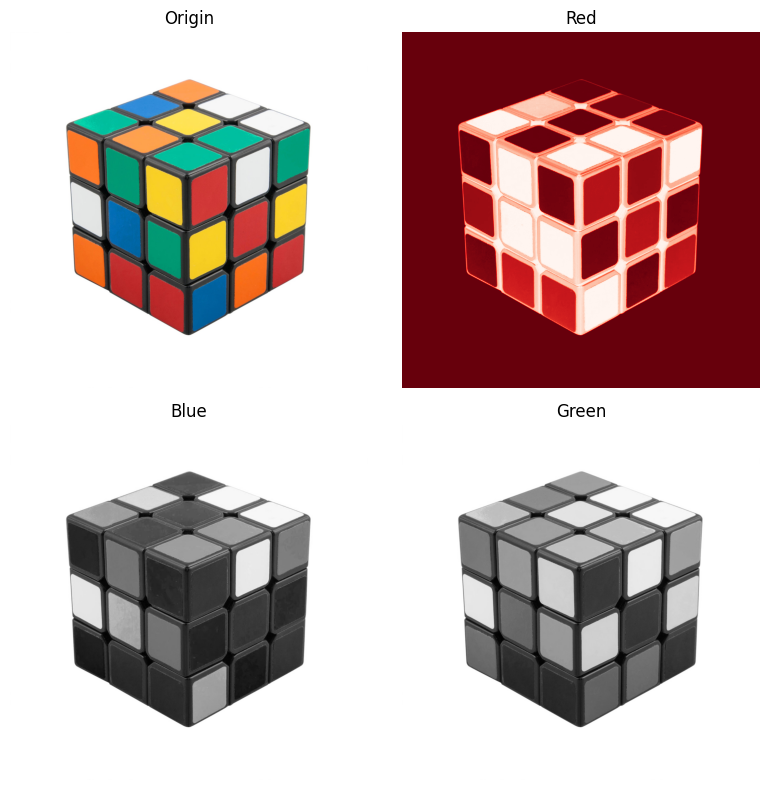

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('images/square.jpeg')

blue, green, red = cv2.split(image)

plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
blur = cv2.GaussianBlur(red, (51, 51), 0)
high_pass = cv2.subtract(red, blur)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
blur = cv2.GaussianBlur(blue, (51, 51), 0)
high_pass = cv2.subtract(blue, blur)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
blur = cv2.GaussianBlur(green, (51, 51), 0)
high_pass = cv2.subtract(green, blur)
plt.imshow(cv2.cvtColor(green, cv2.COLOR_BGR2RGB))
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()